[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/03_VIT_Demo.ipynb)

## VIT Transformer Demo

A short Demo of the VIT and how to extract features from the model.

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTModel

# Load Vision Transformer model (ViT-L/32)
model_name = "google/vit-large-patch32-224-in21k" 
model = ViTModel.from_pretrained(model_name)
model.num_parameters() / 1e9
#model.parameters

0.30656

Model is trained on 224x224 images. With 32x32 pixels per patch, it thus has 224/32=7 patches in each dimension. Details for the model can be found at hugging face model hub [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

## Extracting the class token
For feature extraction, we can use the output of the class token. The class token is the first token in the output of the model. 


In [41]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

# Some image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Correct image processor
processor = ViTImageProcessor.from_pretrained(model_name) 
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print(last_hidden_states.shape, last_hidden_states[:, 0, :])

torch.Size([1, 50, 1024]) tensor([[ 0.0655,  0.0278, -0.2328,  ...,  0.3524, -0.0096,  0.1081]],
       grad_fn=<SliceBackward0>)


## Correlations of the learned positional encodings

Reproducing Figure 7 in the middle from the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al. (2021).

Getting the positional embeddings.

In [42]:
# Extract position embeddings from the model
position_embeddings = model.embeddings.position_embeddings  # Shape: (1, num_patches + 1, hidden_dim)
position_embeddings = position_embeddings.squeeze(0).detach().numpy()  # Remove batch dim

# Exclude class token (first entry)
position_embeddings = position_embeddings[1:]  # Shape: (num_patches, hidden_dim)
position_embeddings.shape #49, 1024 so allthegther we have 49 patches and C=1024

(49, 1024)

Calculating the correlation matrix of the positional embeddings.

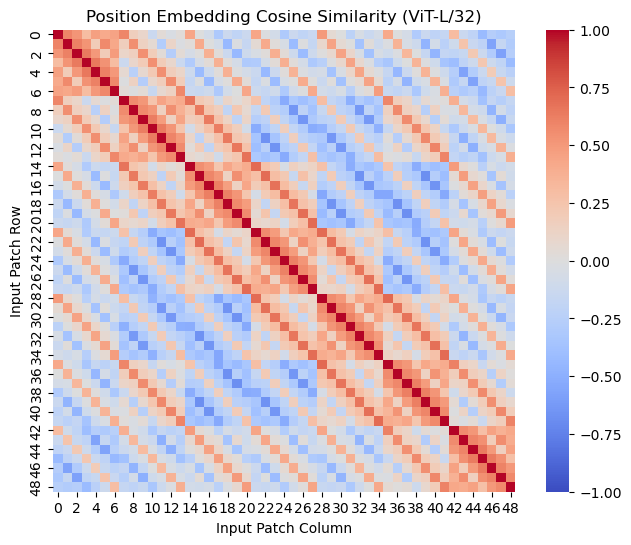

In [37]:
# Compute cosine similarity matrix
def cosine_similarity_matrix(embeddings):
    norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm  # Normalize each vector
    return np.dot(normalized_embeddings, normalized_embeddings.T)  # Cosine similarity

similarity_matrix = cosine_similarity_matrix(position_embeddings)

# Plot the cosine similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()

Better sorting, so that the first block is patch 1 and show the correlation matrix to the other 7 patches.

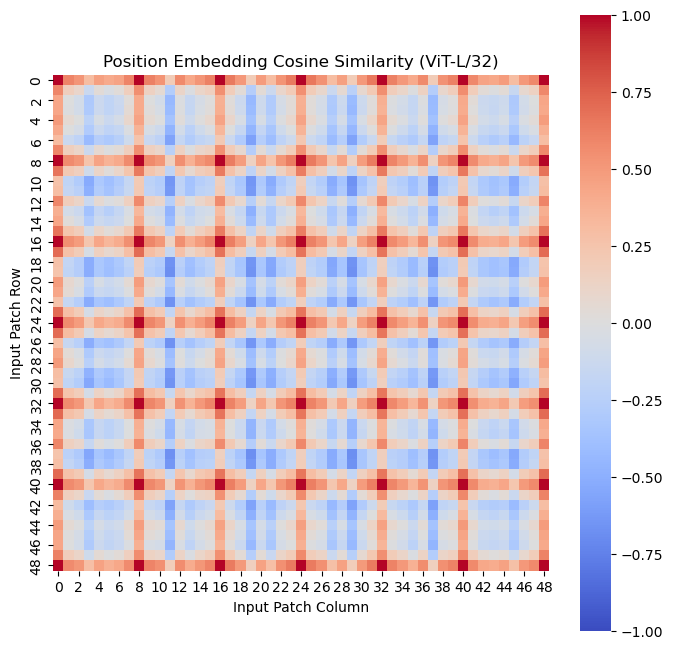

In [38]:
similarity_matrix = cosine_similarity_matrix(position_embeddings)  # Shape: (49, 49)

# Reshape into a (7,7)x(7,7) grid
grid_size = 7
similarity_matrix = similarity_matrix.reshape(grid_size, grid_size, grid_size, grid_size)
similarity_matrix = np.block([[similarity_matrix[i, j] for j in range(grid_size)] for i in range(grid_size)])

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()